# Post-hoc Q-value Analysis - Clean Version

In [1]:
import os
import sys
from matplotlib import animation
sys.path.append("/home/mbortkie/repos/crl_subgoal/src")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

import functools
import distrax
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as display

from impls.agents import agents
from config import SRC_ROOT_DIR
from envs.block_moving_env import *
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs
from impls.utils.networks import GCDiscreteActor

In [2]:
# Configuration
EPISODE_LENGTH = 100
NUM_ENVS = 1024
CHECKPOINT = 50
RUN_NAME = f"DQN{CHECKPOINT}_investigation"
MODEL_PATH = "/home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044157/runs/dqn_1.38_3_grid_4_ep_len__filter_quarter"
FIGURES_PATH = f"/home/mbortkie/repos/crl_subgoal/notebooks/figures/{RUN_NAME}"
os.makedirs(FIGURES_PATH, exist_ok=True)

In [3]:
def display_gif(env, timesteps, idx):
    grid_size = timesteps.grid.shape[-2:]
    fig, ax = plt.subplots(figsize=grid_size)
    # Assets are in repo root, not in src
    assets_path = os.path.join(os.path.dirname(SRC_ROOT_DIR), 'assets')
    animate = functools.partial(env.animate, ax, jax.tree_util.tree_map(lambda x: x[:,idx:].swapaxes(1, 0), timesteps), img_prefix=assets_path)
    anim = animation.FuncAnimation(fig, animate, frames=EPISODE_LENGTH, interval=80, repeat=False)
    gif_path = f"/tmp/block_moving_epoch.gif"
    anim.save(gif_path, writer='pillow')
    plt.close()
    display.display(display.Image(filename=gif_path))

def plot_q_value_difference(agent, states, goals, actions, episode_length, num_envs):
    """Plot the absolute difference between Q1 and Q2 values over timesteps."""
    traj_states_flat = states.reshape((states.shape[0] * states.shape[1], -1))
    traj_goals_flat = goals.reshape((goals.shape[0] * goals.shape[1], -1))
    traj_actions_flat = actions.reshape((actions.shape[0] * actions.shape[1]))
    
    q1, q2 = agent.network.select('critic')(traj_states_flat, traj_goals_flat, traj_actions_flat)
    q1 = q1.reshape((episode_length, num_envs))
    q2 = q2.reshape((episode_length, num_envs))
    
    q_diff = jnp.mean(jnp.abs(q1 - q2), axis=1)
    q_diff_std_error = jnp.std(jnp.abs(q1 - q2), axis=1) / jnp.sqrt(q1.shape[1])
    
    plt.plot(q_diff, label='|q1 - q2|')
    plt.fill_between(np.arange(len(q_diff)), q_diff - q_diff_std_error, 
                     q_diff + q_diff_std_error, alpha=0.2)
    plt.xlabel('Timestep')
    plt.ylabel('Absolute Difference')
    plt.title('Distance between q1 and q2 over Timesteps')
    plt.legend()
    plt.show()

In [4]:
def analyze_setup(agent, config, generator_special=False):
    """Run analysis for a given setup (simple or diagonal)."""
    # Update config
    config.env.generator_special = generator_special
    
    # Create env with updated config
    env = create_env(config.env)
    env = AutoResetWrapper(env)
    key = random.PRNGKey(config.exp.seed)
    env.step = jax.jit(jax.vmap(env.step))
    env.reset = jax.jit(jax.vmap(env.reset))
    
    keys = random.split(random.PRNGKey(0), NUM_ENVS)
    state, info = env.reset(keys)
    
    dummy_timestep = env.get_dummy_timestep(key)
    replay_buffer = jit_wrap(
        TrajectoryUniformSamplingQueue(
            max_replay_size=config.exp.max_replay_size,
            dummy_data_sample=dummy_timestep,
            sample_batch_size=config.exp.batch_size,
            num_envs=config.exp.num_envs,
            episode_length=config.env.episode_length,
        )
    )
    buffer_state = jax.jit(replay_buffer.init)(key)
    
    # Collect data
    data_key = random.PRNGKey(0)
    _, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
    buffer_state = replay_buffer.insert(buffer_state, timesteps)
    
    # Create batch
    jitted_flatten_batch = jax.jit(jax.vmap(flatten_batch, in_axes=(None, None, 0, 0)), static_argnums=(0, 1))
    jitted_create_batch = functools.partial(
        create_batch,
        gamma=config.exp.gamma,
        use_targets=config.exp.use_targets,
        use_future_and_random_goals=config.exp.use_future_and_random_goals,
        jitted_flatten_batch=jitted_flatten_batch,
        use_discounted_mc_rewards=config.agent.use_discounted_mc_rewards,
    )
    
    batch_key = random.PRNGKey(0)
    buffer_state, transitions = replay_buffer.sample(buffer_state)
    batch = jitted_create_batch(transitions, batch_key)
    
    # Compute entropy
    all_actions = jnp.tile(jnp.arange(6), (batch['observations'].shape[0], 1))
    qs = jax.lax.stop_gradient(
        jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(batch['observations'], batch['value_goals'], all_actions)
    )
    qs = qs.min(axis=1).transpose(1, 0)
    dist = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))
    
    plt.hist(dist.entropy())
    plt.title('Entropy Distribution')
    plt.show()
    
    # Process timesteps for Q-value analysis
    use_targets = False
    timesteps_tr = jax.lax.cond(
        use_targets,
        lambda: timesteps.replace(),
        lambda: timesteps.replace(
            grid=remove_targets(timesteps.grid),
            goal=remove_targets(timesteps.goal)
        )
    )
    
    tr_states = timesteps_tr.grid
    tr_actions = timesteps_tr.action
    tr_goals = timesteps_tr.goal
    
    plot_q_value_difference(agent, tr_states, tr_goals, tr_actions, EPISODE_LENGTH, NUM_ENVS)
    
    return env, timesteps

In [5]:
# Initial config
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=4,
        number_of_boxes_min=1,
        number_of_boxes_max=1,
        number_of_moving_boxes_max=1
    )
)

env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
dummy_timestep = env.get_dummy_timestep(key)

In [6]:
# Create example batch and restore agent
example_batch = {
    "observations": dummy_timestep.grid.reshape(1, -1),
    "next_observations": dummy_timestep.grid.reshape(1, -1),
    "actions": jnp.ones((1,), dtype=jnp.int8) * (env._env.action_space - 1),
    "rewards": jnp.ones((1,), dtype=jnp.int8),
    "masks": jnp.ones((1,), dtype=jnp.int8),
    "value_goals": dummy_timestep.grid.reshape(1, -1),
    "actor_goals": dummy_timestep.grid.reshape(1, -1),
}

agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044157/runs/dqn_1.38_3_grid_4_ep_len__filter_quarter/params_50.pkl


# Simple Setup Analysis

2025-10-02 21:47:26.373620: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-10-02 21:47:36.753215: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-10-02 21:47:36.753215: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


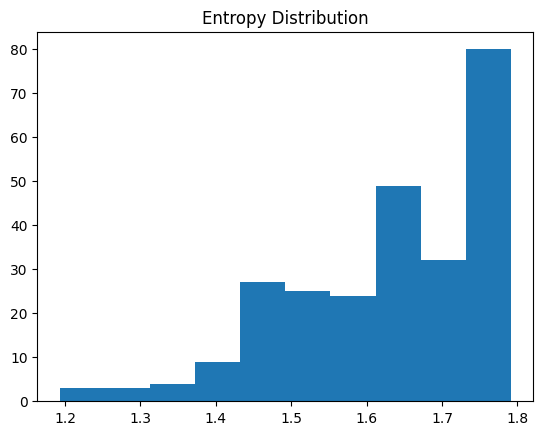

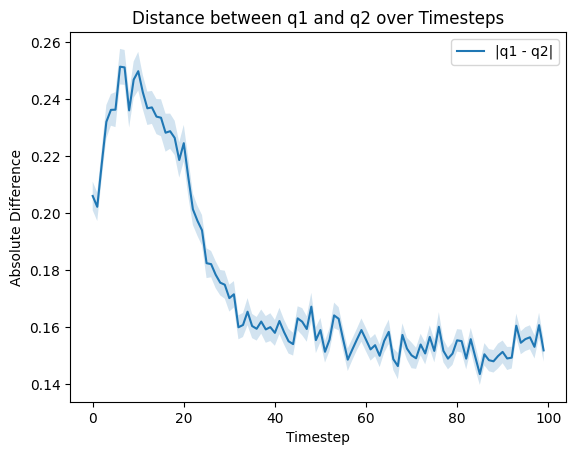

In [7]:
env_simple, timesteps_simple = analyze_setup(agent, config, generator_special=False)

In [8]:
timesteps_simple.grid.shape

(100, 1024, 4, 4)

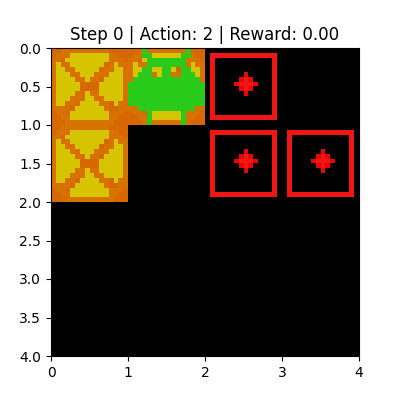

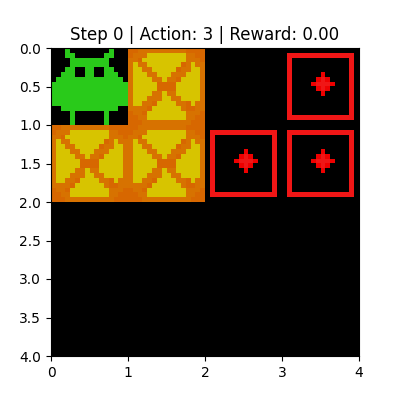

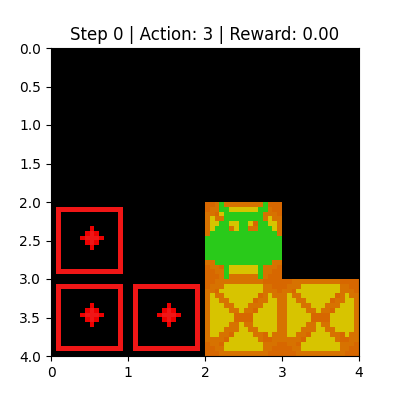

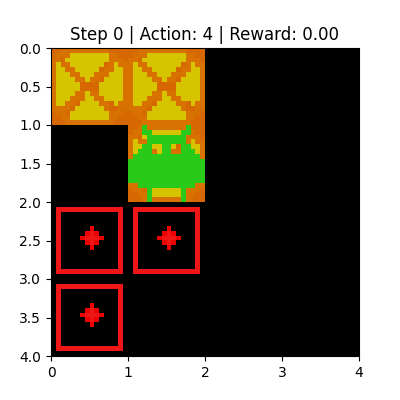

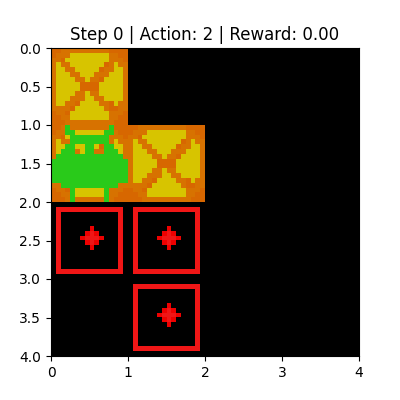

In [9]:
# Display sample trajectories
for idx in range(5):
    display_gif(env_simple, timesteps_simple, idx)

# Diagonal Setup Analysis

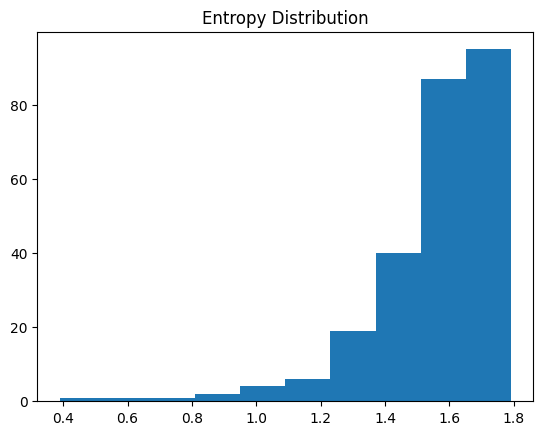

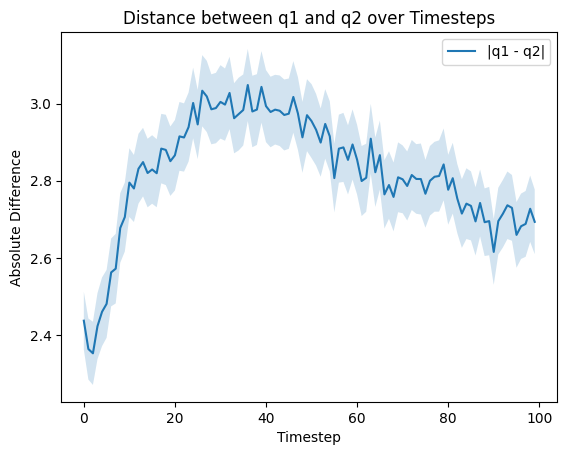

In [10]:
env_diagonal, timesteps_diagonal = analyze_setup(agent, config, generator_special=True)

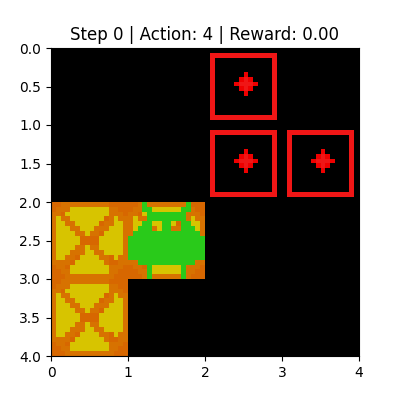

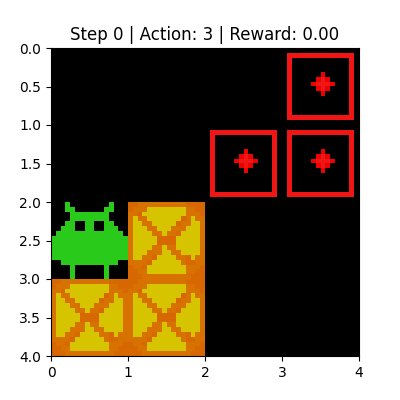

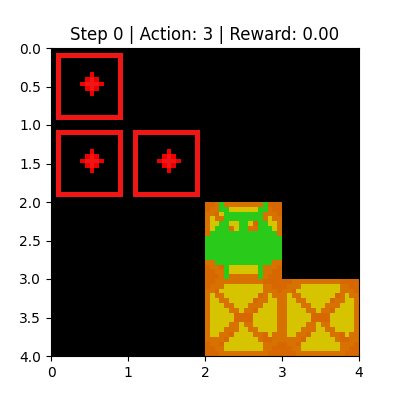

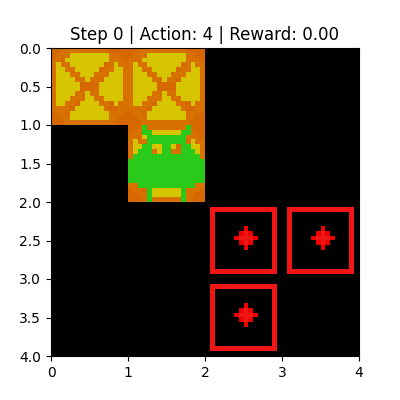

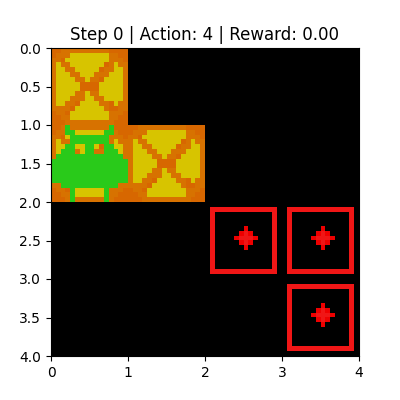

In [11]:
# Display sample trajectories
for idx in range(5):
    display_gif(env_diagonal, timesteps_diagonal, idx)